## Load modules

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

import torch
from torch.autograd import Variable
import torch.nn.functional as F

## Function to scale data (minmax scaling)

In [2]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc    

## Create output folders if needed

In [3]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

In [4]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

In [5]:
data_loc = '../data/sam_1/kfold_5fold/'

In [6]:
# Initialise empty lists
train_data, test_data = [], []

# Read in the names of the selected features for the model
number_of_features_to_use = 10
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append("S2Thrombolysis")

for i in range(5):
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]
    train.rename(columns=feature_name_dict, inplace=True)
    train_data.append(train)
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=feature_name_dict, inplace=True)
    test_data.append(test)

In [7]:
class Net(torch.nn.Module):
    
    def __init__(self, number_features, expansion=2):
        # Define layers
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(number_features, number_features * expansion)
        self.bn1 = torch.nn.BatchNorm1d(number_features * expansion)
        self.fc2 = torch.nn.Linear(number_features * expansion, number_features * expansion)
        self.bn2 = torch.nn.BatchNorm1d(number_features * expansion)
        self.fc3 = torch.nn.Linear(number_features * expansion, 1)
        
    def forward(self, x):
        # Define sequence of layers
        x = self.fc1(x) # Fully connected layer
        x = self.bn1(x) # Batch normalisation
        x = F.dropout(x, p=0.5) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc2(x) # Fully connected layer
        x = self.bn2(x) # Batch normalisation
        x = F.dropout(x, p=0.5) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc3(x) # Fully connected layer
        x = torch.sigmoid(x)
        
        return x

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [9]:
use_hospital = True

# Get k fold split
train = train_data[0]
test = test_data[0]

# Get X and y
X_train = train.drop("Thrombolysis", axis=1)
X_test = test.drop("Thrombolysis", axis=1)
y_train = train["Thrombolysis"]
y_test = test["Thrombolysis"]

if use_hospital:
    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)    
else:
    # Remove stroke team for first test
    X_train = X_train.drop('Stroke team', axis=1)
    X_test = X_test.drop('Stroke team', axis=1)

# Convert to NumPy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Scale data
X_train_sc, X_test_sc = scale_data(X_train, X_test)
    
# Define network
number_features = X_train_sc.shape[1]
    
net = Net(number_features)

# Set batch size (cases per batch - commonly 8-64)
batch_size = 32
# Epochs (number of times to pass over data)
num_epochs = 10
# Learning rate (how much each bacth updates the model)
learning_rate = 0.001
# Calculate numebr of batches
batch_no = len(X_train_sc) // batch_size

# Set up optimizer for classification
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Train model by passing through the data the required number of epochs
for epoch in range(num_epochs):
    print (f'{epoch}', end = ' ')

    # Shuffle
    X_train_sc, y_train = shuffle(X_train_sc, y_train)

    # Set net to training mode
    net.train()


    for i in range(batch_no):
        
        # Get X and y batch data
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(X_train_sc[start:end]))
        y_var = Variable(torch.FloatTensor(y_train[start:end]))

        # These steps train the model: Forward + Backward + Optimize
        optimizer.zero_grad() # reset optimizer
        ypred_var = net(x_var) # predict y
        loss = criterion(ypred_var, y_var.reshape(-1,1)) # Calculate loss
        loss.backward() # Back propagate loss through network
        optimizer.step() # Update network to reduce loss

    # Set net to evaluation mode
    net.eval()

    test_var = Variable(torch.FloatTensor(X_train_sc))
    result = net(test_var)
    values = result.data.numpy().flatten()
    y_pred_train = values >= 0.5
    accuracy_train = np.mean(y_pred_train == y_train)
    
    test_var = Variable(torch.FloatTensor(X_test_sc))
    result = net(test_var)
    values = result.data.numpy().flatten()
    y_pred_test = values >= 0.5
    accuracy_test = np.mean(y_pred_test == y_test)
    print(f'{accuracy_train:0.3f}, {accuracy_test:0.3f}')

0 0.831, 0.824
1 0.835, 0.827
2 0.838, 0.830
3 0.839, 0.832
4 0.839, 0.831
5 0.842, 0.834
6 0.842, 0.833
7 0.841, 0.833
8 0.843, 0.833
9 0.843, 0.833


(array([5317., 1208., 1011.,  860.,  776.,  725.,  669.,  586.,  535.,
         518.,  471.,  475.,  516.,  568.,  665.,  787.,  847.,  750.,
         389.,   86.]),
 array([5.5001268e-26, 4.8206814e-02, 9.6413627e-02, 1.4462043e-01,
        1.9282725e-01, 2.4103406e-01, 2.8924087e-01, 3.3744767e-01,
        3.8565451e-01, 4.3386132e-01, 4.8206812e-01, 5.3027493e-01,
        5.7848173e-01, 6.2668854e-01, 6.7489535e-01, 7.2310221e-01,
        7.7130902e-01, 8.1951582e-01, 8.6772263e-01, 9.1592944e-01,
        9.6413624e-01], dtype=float32),
 <BarContainer object of 20 artists>)

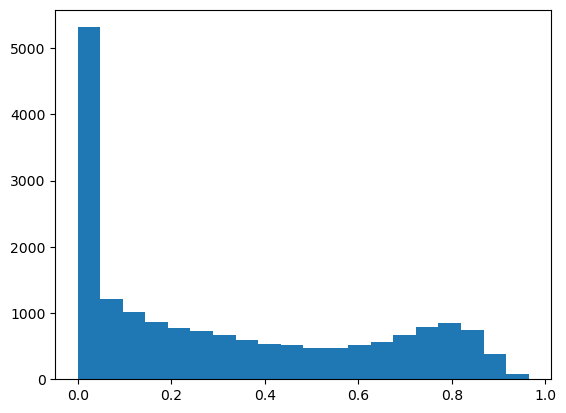

In [10]:
plt.hist(values, bins=20)